In this notebook, we train a CNN model to classify images from the CIFAR-10 database. 

The images are colored images and fall into 10 categories.

In [19]:
## Importing libraries
import torch
import numpy as np

# Libraries for data loading
from torchvision import datasets
import torchvision.transforms as transforms
from torch.utils.data.sampler import SubsetRandomSampler

# Libraries for plotting and visualisation
import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
#Test for CUDA
## Cuda uses GPU and can speed up the training process. Using CUDA can increase the speed in which the model
## trains
train_on_gpu = torch.cuda.is_available()

if train_on_gpu:
    print("CUDA is available")
else:
    print("CUDA is not available")

CUDA is not available


#### Loadind the Data
CIFAR is part of pytorch library so we can download the data and split it into train and test dataset. We will create 
a dataloader for each of these datasets. 

In [5]:
#Number of subprocess to use
num_workers = 0

#Number samples per batch
batch_size = 20

#percentage training set
valid_size = 0.2

# Transform is defined in PyTorch to transform the given data another format.
# Some examples are transforming from numpy array to tensor etc.
# Transform compose accepts a list in which we can pass multiple transformations. 
# Refer to this youtube tutorial for more info - https://www.youtube.com/watch?v=X_QOZEko5uE 
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5), (0.5,0.5,0.5))
])


In [12]:
# Getting training and test Dataset
train_data = datasets.CIFAR10('data', train=True, download = True, transform = transform)
test_data = datasets.CIFAR10('data', train = False, download = True, transform = transform)

# Getting indices and performing training split and validation split
num_train = len(train_data)
indices = list(range(num_train))
np.random.shuffle(indices)
split = int(np.floor(valid_size * num_train))
train_idx, valid_idx = indices[split:], indices[:split]

Files already downloaded and verified
Files already downloaded and verified


#### Why we need dataloaders

When the dataset is huge(in millions) loading everything into the model doesnt make sense as we cant fit all of them to the model and compute gradients for all the data points. This is not efficient. To avoid this we divide the entire dataset into batches of defined size called batch size and got through each batch at once and recompute the gradient and update our weights more formally.  

More formally, we define epoch, batch_size and iterations. 

Epoch - one forward/backward pass through the entire training set.
batch_size - The number of training samples through one forward and backward pass.
iterations - number of passes. Each pass using batch_size number of examples.

Eg: If we have 100 samples in two batches, it takes two iterations to complete 1 epoch. 

In [13]:
# Defining Samplers
train_sampler = SubsetRandomSampler(train_idx)
valid_sampler = SubsetRandomSampler(valid_idx)

In [16]:
# Creating dataloader
train_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = train_sampler, num_workers = num_workers)
valid_loader = torch.utils.data.DataLoader(train_data, batch_size = batch_size, sampler = valid_sampler, num_workers = num_workers)
test_loader = torch.utils.data.DataLoader(test_data, batch_size = batch_size, num_workers = num_workers)

In [17]:
# Specifying the classes
classes = ['airplane', 'automobile', 'bird', 'cat', 'deer','dog','frog','horse','ship','truck']

#### Visualising a batch of training data

In [23]:
def imshow(img):
    # Unnormalize the previously normalised data 
    img = img / 2 + 0.5
    plt.imshow(np.transpose(img, (1, 2, 0)))

<ipython-input-26-5641d83b034f>:9: MatplotlibDeprecationWarning: Passing non-integers as three-element position specification is deprecated since 3.3 and will be removed two minor releases later.
  ax = fig.add_subplot(4, 20/4, idx+1, xticks = [], yticks = [])


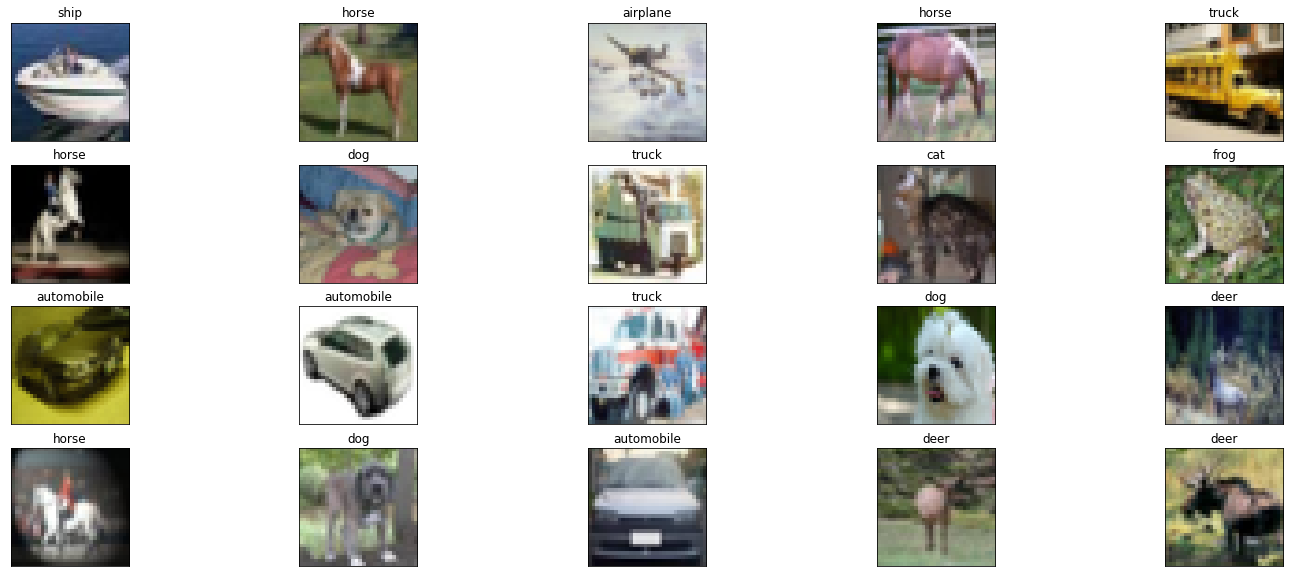

In [26]:
dataiter = iter(train_loader)
images, labels = dataiter.next()
# Converting the image to numpy array for display purpose
images = images.numpy()

# Plotting the images in the batch with corresponding labels.
fig = plt.figure(figsize=(25, 10))
for idx in range(20):
    ax = fig.add_subplot(4, 20/4, idx+1, xticks = [], yticks = [])
    imshow(images[idx])
    ax.set_title(classes[labels[idx]])

##### Defining Network Architrcture and Building the Model

In [30]:
## Importing libraries to build CNN model
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [28]:
class Net(nn.Module):
    def __init__(self):
        super(Net, self).__init__()
        #Conv2d(input_channel, output_channel, Kernal)
        self.conv1 = nn.Conv2d(3, 16, 3, padding = 1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding = 1)
        self.conv3 = nn.Conv2d(32, 64, 3, padding = 1)
        self.pool = nn.MaxPool2d(2, 2)
        self.fc1 = nn.Linear(64*4*4, 500)
        self.fc2 = nn.Linear(500, 10)
        self.dropout = nn.Dropout(0.25)
        
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = self.pool(F.relu(self.conv3(x)))
        
        x = x.view(-1, 64*4*4)
        x = self.dropout(x)
        
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        
        x = self.fc2(x)
        
        return x

In [29]:
model = Net()
print(model)

Net(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=1024, out_features=500, bias=True)
  (fc2): Linear(in_features=500, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [31]:
## Specifying loss function and optimizer
criterion = nn.CrossEntropyLoss()

## Specifying optimizer
optimizer = optim.SGD(model.parameters(), lr = 0.01)

#### Training the model